<font size="+3">Visualize Real and Synthetic Data</font>

# Introduction

The TimeGAN authors assess the quality of the generated data with respect to three practical criteria:
- **Diversity**: the distribution of the synthetic samples should roughly match that of the real data
- **Fidelity**: the sample series should be indistinguishable from the real data, and
- **Usefulness**: the synthetic data should be as useful as their real counterparts for solving a predictive task

They apply three methods to evaluate whether the synthetic data actually exhibits these characteristics:
- **Visualization**: for a qualitative diversity assessment of diversity, we use dimensionality reduction (principal components analysis (PCA) and t-SNE, see Chapter 13) to visually inspect how closely the distribution of the synthetic samples resembles that of the original data
- **Discriminative Score**: for a quantitative assessment of fidelity, the test error of a time-series classifier such as a 2-layer LSTM (see Chapter 18) let’s us evaluate whether real and synthetic time series can be differentiated or are, in fact, indistinguishable.
- **Predictive Score**: for a quantitative measure of usefulness, we can compare the test errors of a sequence prediction model trained on, alternatively, real or synthetic data to predict the next time step for the real data.

We’ll apply and discuss the results of each method in this notebook.

# Imports and Settings

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [3]:
sns.set_style('white')

In [4]:
np.random.seed(42)
tf.random.set_seed(1234)

In [5]:
path = Path('time_gan')
hdf_store = path / 'TimeSeriesGAN.h5'

In [6]:
seq_len = 24
n_seq = 6

# Load Data

In [7]:
experiment = 0

In [10]:
def get_real_data():
    transactions = pd.read_csv('https://raw.githubusercontent.com/BigTuna08/Banksformer_ecml_2022/main/czech/banksformer/data/tr_by_acct_w_age.csv',
                            index_col = 'date', parse_dates=['date'])
    filtered_transactions = transactions.copy()

    # Encode "type" column as 0 for credit and 1 for debit
    filtered_transactions['type'] = filtered_transactions['type'].map({'CREDIT': 0, 'DEBIT': 1})

    # Remove client_id and age columns
    filtered_transactions = filtered_transactions.drop(['client_id', 'age'], axis=1)

    # Encode operations
    operations_dummies = pd.get_dummies(filtered_transactions['operation'])
    filtered_transactions = pd.concat([filtered_transactions, operations_dummies], axis=1)
    filtered_transactions.drop('operation', axis=1, inplace=True)
    filtered_transactions.drop('k_symbol', axis=1, inplace=True)
    filtered_transactions.drop('Unnamed: 0', axis=1, inplace=True)
    filtered_transactions = filtered_transactions[filtered_transactions['account_id'].isin(filtered_transactions['account_id'].unique()[:6])]
    new_df = filtered_transactions.pivot_table(
        values='amount',
        index= 'date',
        columns='account_id'
    ).fillna(0).astype(int)

    # Preprocess the dataset:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(new_df)

    data = []
    for i in range(len(new_df) - seq_len):
        data.append(scaled_data[i:i + seq_len])
    return data


real_data = get_real_data()

In [11]:
n = len(real_data)

In [12]:
np.asarray(real_data).shape

(622, 24, 6)

In [13]:
# synthetic_data = np.load(path / f'experiment_{experiment:02d}' / 'generated_data.npy')
synthetic_data = np.load('generated_data.npy')
synthetic_data.shape

(512, 24, 6)

In [14]:
real_data = real_data[:synthetic_data.shape[0]]

# Prepare Sample

In [15]:
sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

In [16]:
# Data preprocessing
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

In [17]:
real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)

In [18]:
real_sample_2d.shape, synthetic_sample_2d.shape

((1500, 24), (1500, 24))

# Visualization in 2D: A Qualitative Assessment of Diversity

To visualize the real and synthetic series with 24 time steps and six features, we reduce their dimensionality so that we can plot them in two dimensions. To this end, we sample 250 normalized sequences with six features each and reshape them to obtain data with dimensionality 1,500 ⨉ 24.

## Run PCA

PCA is a linear method that identifies a new basis with mutually orthogonal vectors that, successively, capture the directions of maximum variance in the data. We compute the first two components using the real data and then project both real and synthetic samples onto the new coordinate system:

In [19]:
pca = PCA(n_components=2)
pca.fit(real_sample_2d)
pca_real = (pd.DataFrame(pca.transform(real_sample_2d))
            .assign(Data='Real'))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d))
                 .assign(Data='Synthetic'))
pca_result = pca_real.append(pca_synthetic).rename(
    columns={0: '1st Component', 1: '2nd Component'})

<ipython-input-19-6d9674967aa6>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pca_result = pca_real.append(pca_synthetic).rename(


## Run t-SNE

t-SNE is a non-linear manifold learning method for the visualization of high-dimensional data. It converts similarities between data points to joint probabilities and aims to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data (see Chapter 13). We compute t-SNE for the combined real and synthetic data as follows:

In [20]:
tsne_data = np.concatenate((real_sample_2d,
                            synthetic_sample_2d), axis=0)

tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.001s...
[t-SNE] Computed neighbors for 3000 samples in 0.120s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.102740
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.800308
[t-SNE] KL divergence after 1000 iterations: 0.417731


In [21]:
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
tsne_result.loc[sample_size*6:, 'Data'] = 'Synthetic'

## Plot Result

The below figure displays the PCA and t-SNE results for a qualitative assessment of the similarity of the real and synthetic data distributions. Both methods reveal strikingly similar patterns and significant overlap, suggesting that the synthetic data capture important aspects of the real data characteristics.

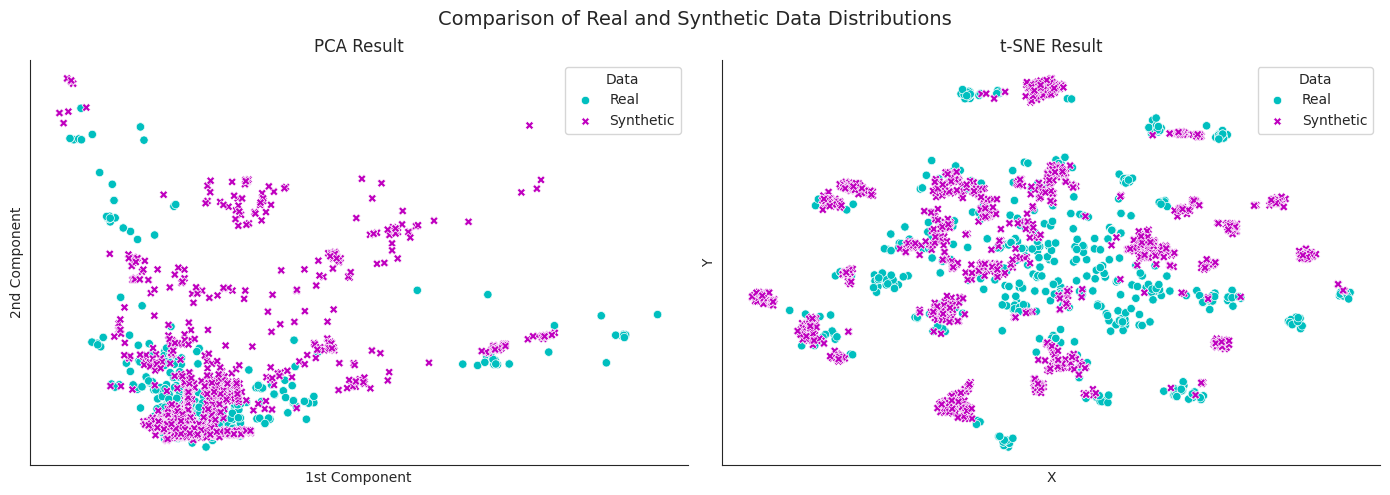

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                hue='Data', style='Data', ax=axes[0], palette=["c", "m"])
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=tsne_result,
                hue='Data',
                style='Data',
                ax=axes[1], palette=["c", "m"])
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions',
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);

# Time Series Classification: A quantitative Assessment of Fidelity

The visualization only provides a qualitative impression. For a quantitative assessment of the fidelity of the synthetic data, we train a time-series classifier to distinguish between real and fake data and evaluate its performance on a held-out test set.

More specifically, we select the first 80 percent of the rolling sequences for training, and the last 20 percent as test set as follows:

## Prepare Data

In [28]:
real_data = get_real_data()
real_data = np.array(real_data)[:len(synthetic_data)]
real_data.shape

(512, 24, 6)

In [29]:
synthetic_data.shape

(512, 24, 6)

In [30]:
n_series = real_data.shape[0]

In [31]:
idx = np.arange(n_series)

In [32]:
n_train = int(.8*n_series)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

In [33]:
train_data = np.vstack((real_data[train_idx],
                        synthetic_data[train_idx]))
test_data = np.vstack((real_data[test_idx],
                       synthetic_data[test_idx]))

In [34]:
n_train, n_test = len(train_idx), len(test_idx)
train_labels = np.concatenate((np.ones(n_train),
                               np.zeros(n_train)))
test_labels = np.concatenate((np.ones(n_test),
                              np.zeros(n_test)))

## Create Classifier

Then we create a simple RNN with six units that receives mini batches of real and synthetic series of shape 24 ⨉ 6 and uses a sigmoid activation. We optimize it using binary cross entropy loss and the Adam optimizer while tracking the AUC and accuracy metrics:

In [35]:
ts_classifier = Sequential([GRU(6, input_shape=(24, 6), name='GRU'),
                            Dense(1, activation='sigmoid', name='OUT')],
                           name='Time_Series_Classifier')

In [36]:
ts_classifier.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=[AUC(name='AUC'), 'accuracy'])

The model has 259 trainable parameters. We train it for 250 epochs on batches of 128 randomly selected samples and track the validation performance:

In [37]:
ts_classifier.summary()

Model: "Time_Series_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU (GRU)                   (None, 6)                 252       
                                                                 
 OUT (Dense)                 (None, 1)                 7         
                                                                 
Total params: 259 (1.01 KB)
Trainable params: 259 (1.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
result = ts_classifier.fit(x=train_data,
                           y=train_labels,
                           validation_data=(test_data, test_labels),
                           epochs=250,
                           batch_size=128,
                           verbose=0)

Once the training completes, evaluation of the test set yields a classification error of almost 56 percent on the balanced test set, and a very low AUC of 0.136.

In [39]:
ts_classifier.evaluate(x=test_data, y=test_labels)

7/7 [==============================] - 0s 9ms/step - loss: 1.8509 - AUC: 0.2269 - accuracy: 0.4951    


[1.850900411605835, 0.22688281536102295, 0.49514561891555786]

In [40]:
history = pd.DataFrame(result.history)
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          250 non-null    float64
 1   AUC           250 non-null    float64
 2   accuracy      250 non-null    float64
 3   val_loss      250 non-null    float64
 4   val_AUC       250 non-null    float64
 5   val_accuracy  250 non-null    float64
dtypes: float64(6)
memory usage: 11.8 KB


The plot shows that that model is not able to learn the difference between the real and synthetic data in a way that generalizes to the test set. This result suggests that the quality of the synthetic data meets the fidelity standard.

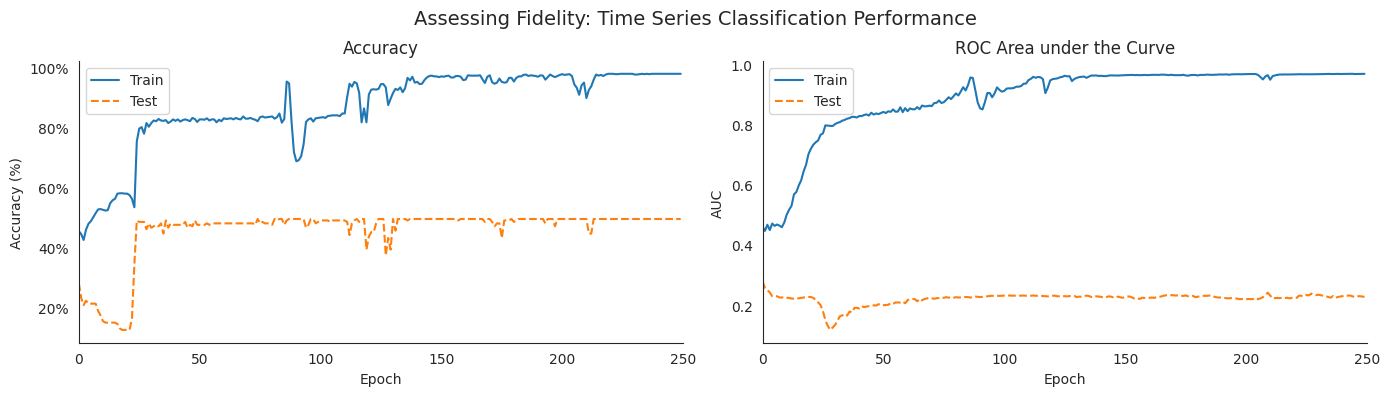

In [41]:
sns.set_style('white')
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
history[['AUC', 'val_AUC']].rename(columns={'AUC': 'Train', 'val_AUC': 'Test'}).plot(ax=axes[1],
                                                                                     title='ROC Area under the Curve',
                                                                                    style=['-', '--'],
                                                                                    xlim=(0, 250))
history[['accuracy', 'val_accuracy']].rename(columns={'accuracy': 'Train', 'val_accuracy': 'Test'}).plot(ax=axes[0],
                                                                                                         title='Accuracy',
                                                                                                        style=['-', '--'],
                                                                                                        xlim=(0, 250))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_ylabel('Accuracy (%)')
axes[1].set_ylabel('AUC')
sns.despine()
fig.suptitle('Assessing Fidelity: Time Series Classification Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

# Train on synthetic, test on real: Assessing usefulness

Finally, we want to know how useful synthetic data is when it comes to solving a prediction problem. To this end, we train a time-series prediction model alternatively on the synthetic and the real data to predict the next time step and compare the performance on a test set create from the real data.

## Prepare Data

In [42]:
real_data = get_real_data()
real_data = np.array(real_data)[:len(synthetic_data)]

In [43]:
real_data.shape, synthetic_data.shape

((512, 24, 6), (512, 24, 6))

More specifically, we select the first 23 time steps of each sequence as input, and the final time step as output. At the same time, we split the real data into train and test set using the same temporal split as in the previous classification example:

In [44]:
real_train_data = real_data[train_idx, :23, :]
real_train_label = real_data[train_idx, -1, :]

real_test_data = real_data[test_idx, :23, :]
real_test_label = real_data[test_idx, -1, :]

In [45]:
real_train_data.shape, real_train_label.shape, real_test_data.shape, real_test_label.shape

((409, 23, 6), (409, 6), (103, 23, 6), (103, 6))

We select the complete synthetic data for training since abundance is one of the reasons we generated it in the first place:

In [46]:
synthetic_train = synthetic_data[:, :23, :]
synthetic_label = synthetic_data[:, -1, :]

In [47]:
synthetic_train.shape, synthetic_label.shape

((512, 23, 6), (512, 6))

## Create RNN

We create a one-layer RNN with 12 GRU units that predicts the last time steps for the six stock price series and, thus, has six linear output units. The model uses the Adam optimizer to minimize the mean absolute error (MAE):

In [48]:
def get_model():
    model = Sequential([GRU(12,
                            input_shape=(seq_len-1,
                                         n_seq)),
                        Dense(6)])

    model.compile(optimizer=Adam(),
                  loss=MeanAbsoluteError(name='MAE'))
    return model

## Train model

We train the model twice using the synthetic and real data for training, respectively, and the real test set to evaluate the out-of-sample performance. Training on synthetic data works as follows, training on real data works analogously (see notebook):

In [49]:
ts_regression = get_model()
synthetic_result = ts_regression.fit(x=synthetic_train,
                                     y=synthetic_label,
                                     validation_data=(
                                         real_test_data,
                                         real_test_label),
                                     epochs=100,
                                     batch_size=128,
                                     verbose=0)

In [50]:
synthetic_result = pd.DataFrame(synthetic_result.history).rename(columns={'loss': 'Train',
                                                                          'val_loss': 'Test'})

In [51]:
ts_regression = get_model()
real_result = ts_regression.fit(x=real_train_data,
                                y=real_train_label,
                                validation_data=(
                                    real_test_data,
                                    real_test_label),
                                epochs=100,
                                batch_size=128,
                                verbose=0)

## Evaluate results

In [52]:
real_result = pd.DataFrame(real_result.history).rename(columns={'loss': 'Train',
                                                                'val_loss': 'Test'})

The below figure plots the MAE on the train and test set (on a log scale so we can spot the difference) for both models. It turns out that the MAE is slightly lower after training on the synthetic dataset.

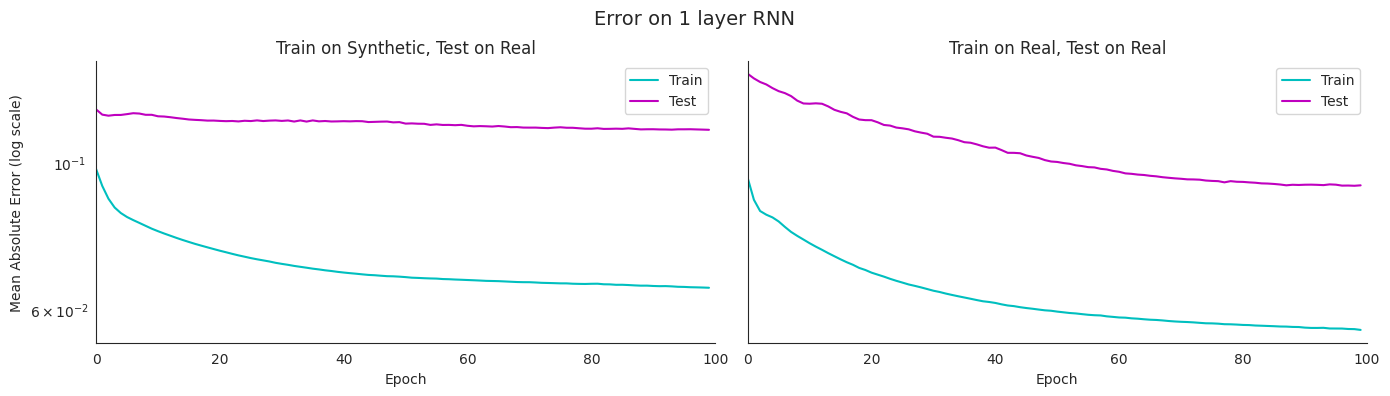

In [55]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

synthetic_result.plot(ax=axes[0], title='Train on Synthetic, Test on Real',
                      logy=True,
                      xlim=(0, 100), color=['c', 'm'])
real_result.plot(ax=axes[1], title='Train on Real, Test on Real',
                 logy=True,
                 xlim=(0, 100), color= ['c', 'm'])

for i in [0, 1]:
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Mean Absolute Error (log scale)')

sns.despine()
fig.suptitle('Error on 1 layer RNN', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

The result shows that synthetic training data may indeed be useful. On the specific predictive task of predicting the next daily stock price for six tickers, a  simple model trained on synthetic TimeGAN data delivers equal or better performance than training on real data.